In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Densité spectrale du bruit d'une machine à laver

In [99]:
from scipy.io.wavfile import read
samplerate, amplitude = read('data/machine_a_laver.wav')
print(samplerate)

44100


In [16]:
N = len(amplitude); deltaT = 1/samplerate; T = N*deltaT;
print(N)

414380


Text(0,0.5,'Amplitude')

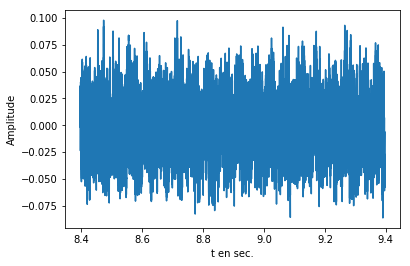

In [24]:
signal = amplitude[N-round(1/deltaT):N];
x = np.linspace((N-round(1/deltaT))*deltaT,N*deltaT,len(signal))
plt.plot(x,signal)
plt.xlabel('t en sec.')
plt.ylabel('Amplitude')

In [25]:
from scipy.signal import periodogram
freq, psd = periodogram(amplitude, samplerate, )

In [41]:
freqList = list(freq);
psdList = list(psd)
frequences = [i for i in freqList if i>=10 and i<=50];
dsp = [psdList[i] for i,j in enumerate(freqList) if j>=10 and j<=50];

Text(0,0.5,'DSP')

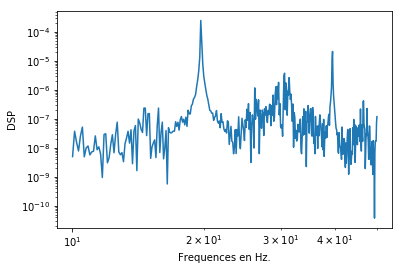

In [43]:
plt.loglog(frequences,dsp)
plt.xlabel('Frequences en Hz.')
plt.ylabel('DSP')

Rotation du tambour: 20 Hz
DSP du bruit : V²/Hz.
DSP du bruit typiquement vers 10^-7 V^2/Hz.

In [78]:
meanPower = 0;
for i in range(len(amplitude)-1):
    meanPower += ((amplitude[i]+amplitude[i+1])/2)**2*deltaT
meanPower = meanPower/T;
print(meanPower)

meanPower = sum((amplitude**2*deltaT))/T
print(meanPower)

0.0005682345053861394
0.0006080771214276977


In [80]:
meanPowerFreq = sum(psd*freq)
print(meanPowerFreq)

11.586875752839855


In [76]:
frequencesBruit = [i for i in freqList if i>=10 and i<=17];
DSPb = [psdList[i] for i,j in enumerate(freqList) if j>=10 and j<=17];
frequencesSignal = [i for i in freqList if i>=17 and i<=23];
DSPs = [psdList[i] for i,j in enumerate(freqList) if j>=17 and j<=23];
#plt.loglog(frequencesSignal,DSPs)
#plt.xlabel('Frequences en Hz.')
#plt.ylabel('DSP')

meanPowerBruit = sum(np.array(DSPb)*np.array(frequencesBruit))
print(meanPowerBruit)

meanPowerSignal = sum(np.array(DSPs)*np.array(frequencesSignal))
print(meanPowerSignal)

SNR = meanPowerSignal/meanPowerBruit;
print(SNR)

3.5051506685266315e-05
0.006648946232807661
189.69073975934123


Bande passante:


## Filtre en Python

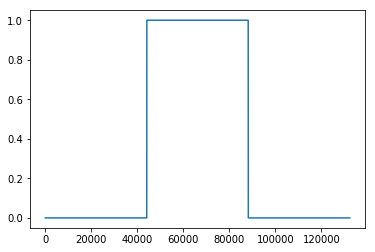

In [84]:
samplerate = 44100
signal = np.zeros(samplerate*3)
signal[samplerate:samplerate*2] = 1
plt.plot(signal)

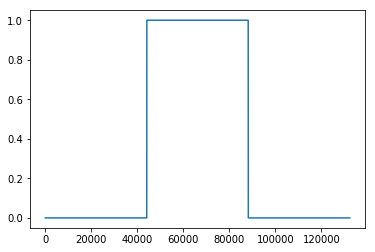

In [85]:
signal_tilde = np.fft.rfft(signal)
signal_2 = np.fft.irfft(signal_tilde)
plt.plot(signal_2)

In [89]:
essai = np.fft.rfftfreq(signal.size,1./samplerate);
print(essai)

[0.00000000e+00 3.33333333e-01 6.66666667e-01 ... 2.20493333e+04
 2.20496667e+04 2.20500000e+04]


In [113]:
def pass_bas(signal, f_c, samplerate=44100):
    signal_tilde = np.fft.rfft(signal) # TF discrete du signal
    freqs = np.fft.rfftfreq(len(signal), 1/samplerate) # Frequences 
    H = 1/(1+1J*(freqs/f_c))
    signal_2 = np.fft.irfft(H*signal_tilde)
    return signal_2

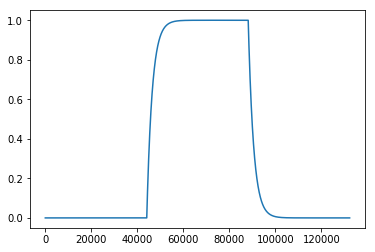

In [126]:
signalFiltre = pass_bas(signal, 3)
#freq = np.linspace(0,1/samplerate*len(signal),len(signalFiltre))
plt.plot(signalFiltre)

In [130]:
def pass_haut(signal, f_c, samplerate=44100):
    signal_tilde = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(len(signal), 1/samplerate)
    H = 1J*(freqs/f_c)/(1+1J*(freqs/f_c))
    signal_2 = np.fft.irfft(H*signal_tilde)
    return signal_2

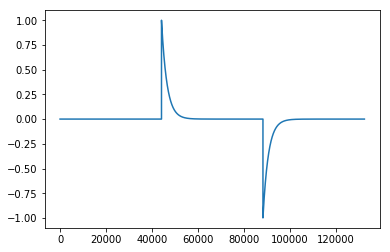

In [138]:
signalFiltre = pass_haut(signal, 3)
plt.plot(signalFiltre)

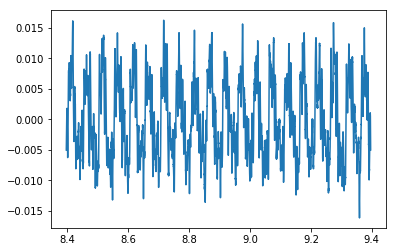

In [146]:
signal = amplitude[N-round(1/deltaT):N];
x = np.linspace((N-round(1/deltaT))*deltaT,N*deltaT,len(signal))
signalFiltre = pass_bas(signal,30,samplerate)
plt.plot(x,signalFiltre)

In [148]:
0.015/np.sqrt(2)

0.010606601717798212

## Onde gravitationnelle

In [149]:
from readligo import loaddata
filename_H1 = 'data/H-H1_LOSC_4_V1-1126259446-32.hdf5'
strain_H1, time_H1, chan_dict_H1 = loaddata(filename_H1, 'H1')

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
f, psd = welch(strain_H1, samplerate, nperseg=samplerate)

In [ ]:
from scipy.interpolate import interp1d    

def whiten(strain, dt):
    freqs_welch, psd_welch = welch(strain, fs=1/dt, nperseg=int(1/dt))
    interp_psd = interp1d(freqs_welch, psd_welch)

    strain_tilde = np.fft.rfft(strain)
    N = len(strain)
    freqs = np.fft.rfftfreq(N, dt)

    gain = 1 / np.sqrt(interp_psd(freqs))
    gain = gain/gain.max()
    white_strain_tilde = strain_tilde * gain
    white_strain = np.fft.irfft(white_strain_tilde)